In [1]:
!pip install 'gluonts[torch]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.2.2
    Uninstalling pytorch-lightning-2.2.2:
      Successfully uninstalled pytorch-lightning-2.2.2


In [3]:
import pandas as pd
import numpy as np
from gluonts.dataset.pandas import PandasDataset
from gluonts.torch.model.deepar import DeepAREstimator
#from gluonts.torch.distributions import NegativeBinomialOutput
#from gluonts.torch.distributions import PoissonOutput
from gluonts.torch.distributions import NormalOutput
from gluonts.evaluation import make_evaluation_predictions
import matplotlib.pyplot as plt
import json

# Split train and test
df = pd.read_csv('../input/wiki-data/Wiki_process_for_deepar.csv')
df.set_index('Date',inplace=True)
#df.index = pd.to_datetime(df.index).dt.strftime('%Y-%m-%d %H:%M:%S')
prediction_length = 15
freq = 'D'
split_date = pd.to_datetime('2016-12-17').strftime('%Y-%m-%d %H:%M:%S')
train = df[df.index < split_date]
test = df[df.index >= split_date]

train.reset_index(inplace=True)
test.reset_index(inplace=True)

train1 = train.drop_duplicates(subset=['Node','Code','Agent','Access','State'])
train_static = pd.DataFrame({'State':train1['State'],
                             'Access':train1['Access'],
                             'Agent':train1['Agent'],
                             'Code':train1['Code'],
                             'Node':train1['Node']})
train_static.set_index('Node',inplace=True)

train_group = train.groupby('Node')
standardized_params = {}
train_standard = train.copy()

train_standard['Value'] = train_standard['Value'].astype(float)
for cat,group in train_group:
    train_group = train.groupby('Node')
    means = group['Value'].mean()
    stds = group['Value'].std()
    standardized_params[cat] = {'mean':means,'std':stds}
    train_standard.loc[group.index,'Value'] = (group['Value']-float(means))/float(stds)

In [4]:
train_standard.head()

,Date,Node,Value,Day_of_Week,Day_Of_Month,Month_Of_Year,Code,Agent,Access,State
0,2016-01-01 00:00:00,Total,0.813018,4,1,1,0,0,0,0
1,2016-01-01 00:00:00,de,-0.049847,4,1,1,0,0,0,1
2,2016-01-01 00:00:00,en,0.998409,4,1,1,0,0,0,2
3,2016-01-01 00:00:00,fr,3.943734,4,1,1,0,0,0,3
4,2016-01-01 00:00:00,ja,0.062315,4,1,1,0,0,0,4


In [10]:
train_ds = PandasDataset.from_long_dataframe(train_standard.iloc[:,[0,1,2,3,4,5]],
                                             target="Value",
                                             timestamp='Date',
                                             freq='D',
                                             item_id="Node",
                                             feat_dynamic_real=['Day_of_Week','Day_Of_Month','Month_Of_Year'],
                                             static_features=train_static)

# Estimator
estimator = DeepAREstimator(freq=freq,
                            prediction_length=prediction_length,
                            context_length=10*prediction_length,
                            num_layers=2,
                            hidden_size=35,
                            lr=1e-3,
                            weight_decay=1e-8,
                            dropout_rate=0.1,
                            num_feat_dynamic_real=3,
                            num_feat_static_real=4,
                            distr_output=NormalOutput(),
                            scaling=False,
                            num_parallel_samples=1000,
                            batch_size=64,
                            trainer_kwargs={'accelerator':'gpu','max_epochs':200})


In [11]:
# Train
import time

st = time.time()

predictor = estimator.train(train_ds,num_workers=4,ckpt_path = './lightning_logs/version_0/checkpoints/epoch=173-step=8700.ckpt')

et = time.time()
print(et-st)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: Restoring states from the checkpoint path at ./lightning_logs/version_0/checkpoints/epoch=173-step=8700.ckpt
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:347: The dirpath has changed from '/kaggle/working/lightning_logs/version_0/checkpoints' to '/kaggle/working/lightning_logs/version_2/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | In sizes                                 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 174, global step 8750: 'train_loss' reached -0.13097 (best -0.13097), saving model to '/kaggle/working/lightning_logs/version_2/checkpoints/epoch=174-step=8750.ckpt' as top 1
INFO: Epoch 175, global step 8800: 'train_loss' was not in top 1
INFO: Epoch 176, global step 8850: 'train_loss' was not in top 1
INFO: Epoch 177, global step 8900: 'train_loss' reached -0.13437 (best -0.13437), saving model to '/kaggle/working/lightning_logs/version_2/checkpoints/epoch=177-step=8900.ckpt' as top 1
INFO: Epoch 178, global step 8950: 'train_loss' was not in top 1
INFO: Epoch 179, global step 9000: 'train_loss' was not in top 1
INFO: Epoch 180, global step 9050: 'train_loss' reached -0.15427 (best -0.15427), saving model to '/kaggle/working/lightning_logs/version_2/checkpoints/epoch=180-step=9050.ckpt' as top 1
INFO: Epoch 181, global step 9100: 'train_loss' was not in top 1
INFO: Epoch 182, global step 9150: 'train_loss' was not in top 1
INFO: Epoch 183, global step 9200: 'train_loss' r

167.324848651886


In [9]:
ls ./lightning_logs/version_0/checkpoints/epoch=173-step=8700.ckpt

'epoch=173-step=8700.ckpt'


T
ja_AAC_AAG_047
113
zh_AAC_AAG
171
ru
141
zh_AAC_SPD
179


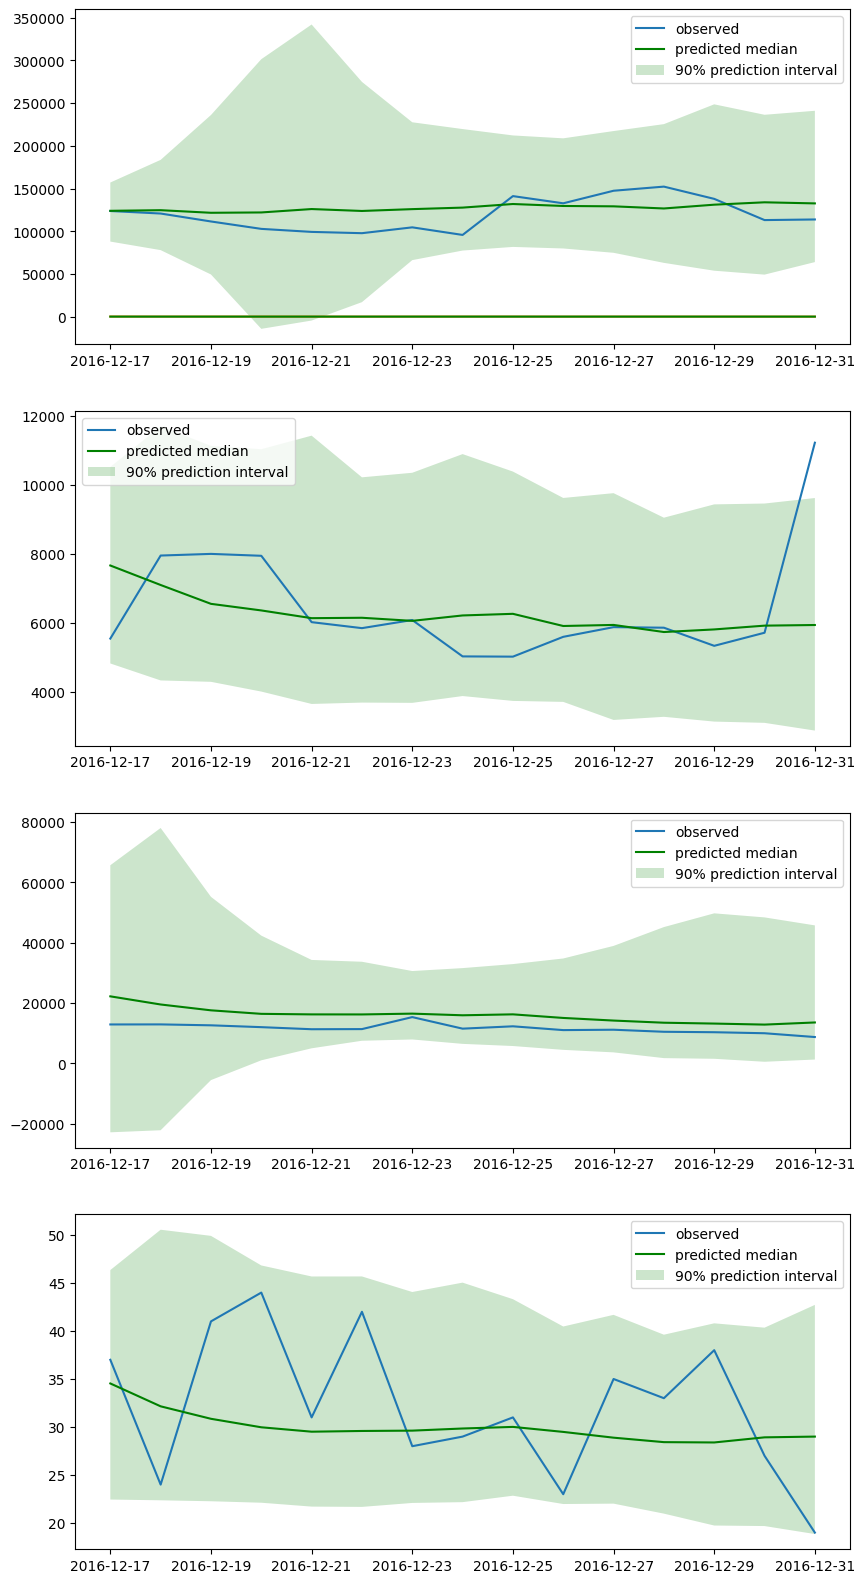

In [12]:
# Evaluation
test1 = test.drop_duplicates(subset=['Node','Code','Agent','Access','State'])
test_static = pd.DataFrame({'State':test1['State'],
                             'Access':test1['Access'],
                             'Agent':test1['Agent'],
                             'Code':test1['Code'],
                             'Node':test1['Node']})
test_static.set_index('Node',inplace=True)

test_ds = PandasDataset.from_long_dataframe(test.iloc[:,[0,1,2,3,4,5]],
                                             target="Value",
                                             item_id="Node",
                                             feat_dynamic_real=['Day_of_Week','Day_Of_Month','Month_Of_Year'],
                                             static_features=test_static,
                                             timestamp='Date',
                                             freq='D')

forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds, predictor=predictor,num_samples=1000)
forecasts = list(forecast_it)
tests = list(ts_it)

# Anti standardized
f_cp = forecasts
for index in range(len(forecasts)):
    index_mean = standardized_params[forecasts[index].item_id]['mean']
    index_std = standardized_params[forecasts[index].item_id]['std']
    f_cp[index].samples = (forecasts[index].samples)*index_std+index_mean


# Plot
n_plot = 4
indices = np.random.choice(np.arange(0, 199), size=n_plot, replace=False)
fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot * 5))


num = 1
for index, ax in zip(indices, axes):
    if num == 1:
        print('T')
        ax.plot(tests[0].to_timestamp())
        plt.sca(ax)
        f_cp[0].plot(intervals=(0.9,), color="g")
        plt.legend(["observed", "predicted median", "90% prediction interval"])
        num+=1
    print(forecasts[index].item_id)
    print(index)
    ax.plot(tests[index].to_timestamp())
    plt.sca(ax)
    f_cp[index].plot(intervals=(0.9,), color="g")
    plt.legend(["observed", "predicted median", "90% prediction interval"])
plt.savefig('./fig.png')
plt.show()

# sort
node_nonsort = []
new_df = pd.read_csv('../input/wiki-data/Wiki_process.csv')
node_list = new_df.columns[1:]
for i in range(len(forecasts)):
    node_nonsort.append(forecasts[i].item_id)
index_list = [node_nonsort.index(i) for i in node_list]

# Save the distri params
distr_params = []
for j in range(15):
    params_mean = []
    params_var = []
    for i in range(len(forecasts)):
        params_mean.append(float(np.mean(forecasts[i].samples[:,j])))
        params_var.append(float(np.var(forecasts[i].samples[:,j],ddof=1)))
    distr_params.append([params_mean,params_var])

distr_params_new = distr_params
for j in range(15):
    distr_params_new[j][0] = [distr_params[j][0][i] for i in index_list]
    distr_params_new[j][1] = [distr_params[j][1][i] for i in index_list]
    


In [13]:
with open('./Wiki_deepar_e200_optuna.json','w') as file:
    file.write(json.dumps(distr_params_new))

In [14]:
!cat './Wiki_deepar_e200_optuna.json'

[[[123635.0546875, 19079.068359375, 51494.73046875, 16645.6796875, 26061.748046875, 22360.890625, 12042.9140625, 10488.859375, 1710.3427734375, 4007.141845703125, 26044.955078125, 15647.017578125, 12575.4267578125, 9082.005859375, 5155.39013671875, 4103.515625, 11443.1962890625, 1352.532958984375, 5131.4404296875, 4926.94140625, 5057.2998046875, 4910.72021484375, 7006.76318359375, 3258.8603515625, 613.8960571289062, 10985.7587890625, 69.83196258544922, 1573.7467041015625, 4156.67138671875, 24548.19921875, 673.6259765625, 13895.7978515625, 11110.181640625, 8127.89697265625, 86.82658386230469, 5576.4931640625, 3950.633544921875, 8999.0947265625, 887.692138671875, 1208.755859375, 4633.6103515625, 4006.81005859375, 90.23787689208984, 5654.4921875, 5388.40771484375, 7609.34228515625, 34.54163360595703, 3567.49853515625, 688.989990234375, 1039.950927734375, 1336.0208740234375, 2779.179443359375, 443.8584289550781, 979.6571044921875, 538.4774780273438, 490.2565612792969, 137.8691864013672, 40